In [ ]:
import tensorflow as tf
import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display

In [ ]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70770688/70763455 [==============================] - 27s 0us/step


In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

In [ ]:
train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [ ]:
def scaling(input_image):
  input_image = input_image / 255.0
  return input_image

# scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = train_ds.map(scaling)

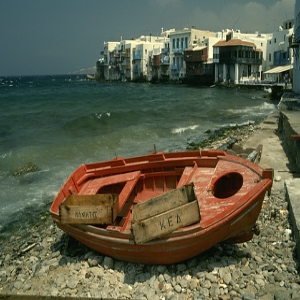

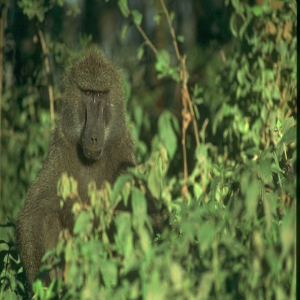

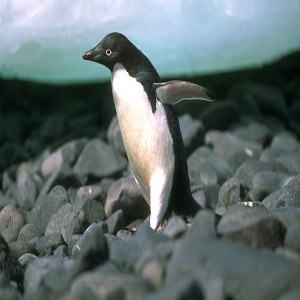

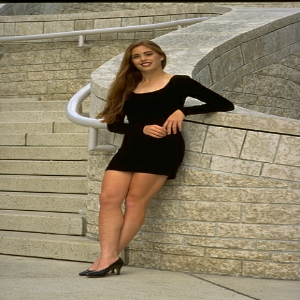

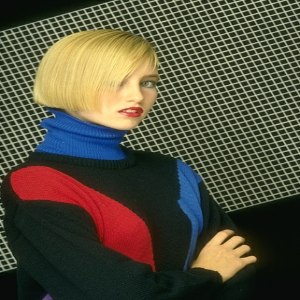

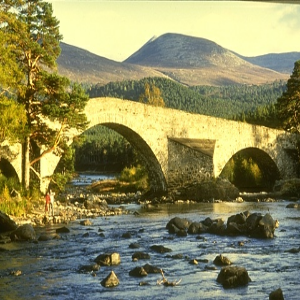

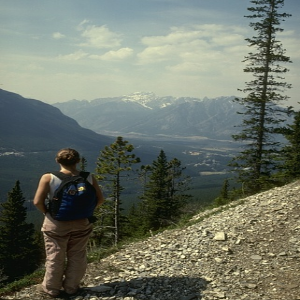

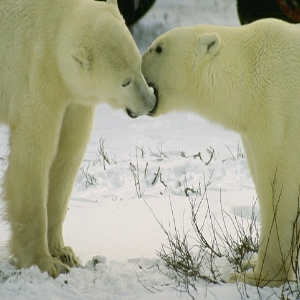

In [ ]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)


In [ ]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)


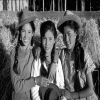

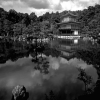

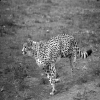

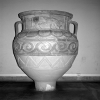

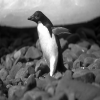

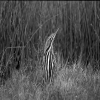

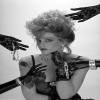

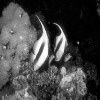

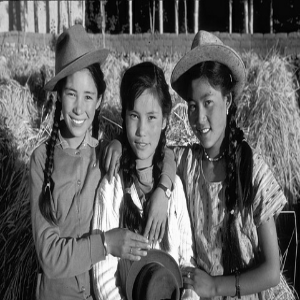

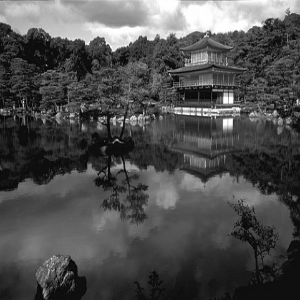

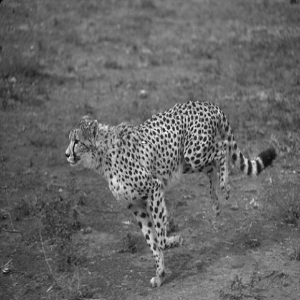

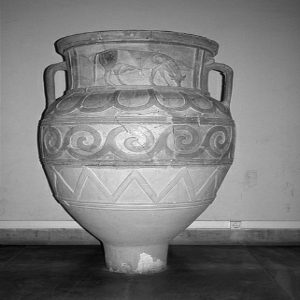

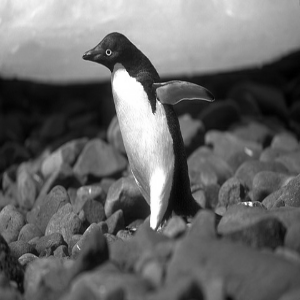

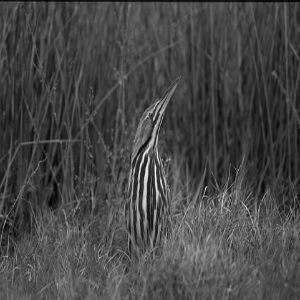

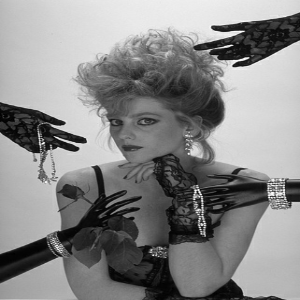

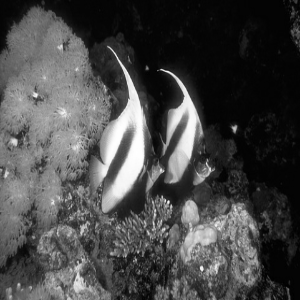

In [ ]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


In [ ]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [ ]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
50/50 [==============================] - 9s 45ms/step - loss: 0.0557 - val_loss: 2.5536e-04
Mean PSNR for epoch: 35.93


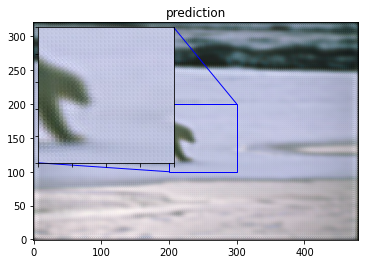

Epoch 2/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0062 - val_loss: 6.0559e-04
Mean PSNR for epoch: 32.18
Epoch 3/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0040 - val_loss: 2.9886e-04
Mean PSNR for epoch: 35.26
Epoch 4/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0033 - val_loss: 1.7509e-04
Mean PSNR for epoch: 37.57
Epoch 5/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0030 - val_loss: 2.0923e-04
Mean PSNR for epoch: 36.79
Epoch 6/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0031 - val_loss: 1.7482e-04
Mean PSNR for epoch: 37.58
Epoch 7/100
50/50 [==============================] - 3s 63ms/step - loss: 0.0031 - val_loss: 1.1256e-04
Mean PSNR for epoch: 39.49
Epoch 8/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0030 - val_loss: 1.0975e-04
Mean PSNR for epoch: 39.60
Epoch 9/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0029 - 

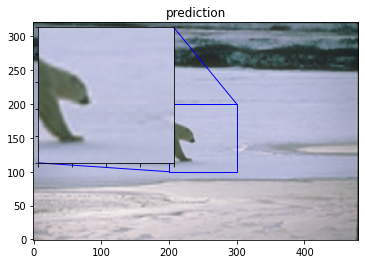

Epoch 22/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0029 - val_loss: 1.0148e-04
Mean PSNR for epoch: 39.94
Epoch 23/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0028 - val_loss: 1.3267e-04
Mean PSNR for epoch: 38.77
Epoch 24/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0027 - val_loss: 1.0425e-04
Mean PSNR for epoch: 39.83
Epoch 25/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0027 - val_loss: 1.5456e-04
Mean PSNR for epoch: 38.11
Epoch 26/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0027 - val_loss: 1.6161e-04
Mean PSNR for epoch: 37.91
Epoch 27/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0028 - val_loss: 1.1693e-04
Mean PSNR for epoch: 39.31
Epoch 28/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0026 - val_loss: 1.1804e-04
Mean PSNR for epoch: 39.28
Epoch 29/100
50/50 [==============================] - 3s 61ms/step - loss: 0

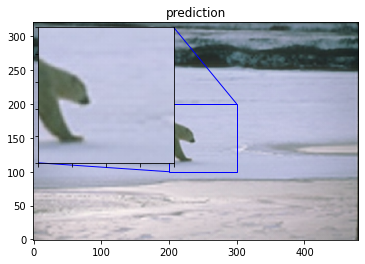

Epoch 42/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0026 - val_loss: 1.9559e-04
Mean PSNR for epoch: 37.09
Epoch 43/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0027 - val_loss: 1.7219e-04
Mean PSNR for epoch: 37.64
Epoch 44/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0027 - val_loss: 1.6509e-04
Mean PSNR for epoch: 37.83
Epoch 45/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0028 - val_loss: 1.6989e-04
Mean PSNR for epoch: 37.70
Epoch 46/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0027 - val_loss: 1.5916e-04
Mean PSNR for epoch: 37.97
Epoch 47/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0026 - val_loss: 1.6838e-04
Mean PSNR for epoch: 37.74
Epoch 48/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0026 - val_loss: 2.0328e-04
Mean PSNR for epoch: 36.93
Epoch 49/100
50/50 [==============================] - 3s 60ms/step - loss: 0

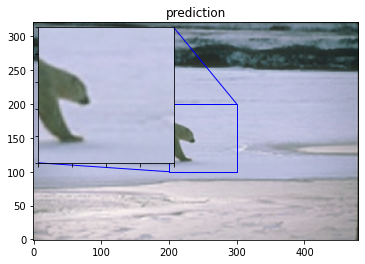

Epoch 62/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0025 - val_loss: 2.9132e-04
Mean PSNR for epoch: 35.35
Epoch 63/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0025 - val_loss: 2.9703e-04
Mean PSNR for epoch: 35.27
Epoch 64/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0026 - val_loss: 3.0354e-04
Mean PSNR for epoch: 35.17
Epoch 65/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0025 - val_loss: 3.1330e-04
Mean PSNR for epoch: 35.04
Epoch 66/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0027 - val_loss: 2.6509e-04
Mean PSNR for epoch: 35.75
Epoch 67/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0026 - val_loss: 3.0487e-04
Mean PSNR for epoch: 35.15
Epoch 68/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0026 - val_loss: 2.7953e-04
Mean PSNR for epoch: 35.53
Epoch 69/100
50/50 [==============================] - 3s 61ms/step - loss: 0

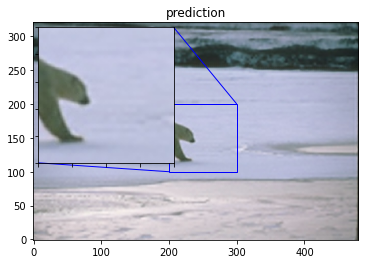

Epoch 82/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0025 - val_loss: 3.5099e-04
Mean PSNR for epoch: 34.55
Epoch 83/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0025 - val_loss: 3.3225e-04
Mean PSNR for epoch: 34.79
Epoch 84/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0026 - val_loss: 3.7892e-04
Mean PSNR for epoch: 34.22
Epoch 85/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0025 - val_loss: 3.7183e-04
Mean PSNR for epoch: 34.29
Epoch 86/100
50/50 [==============================] - 3s 60ms/step - loss: 0.0025 - val_loss: 3.6585e-04
Mean PSNR for epoch: 34.37
Epoch 87/100
50/50 [==============================] - 3s 62ms/step - loss: 0.0026 - val_loss: 3.7354e-04
Mean PSNR for epoch: 34.29
Epoch 88/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0029 - val_loss: 5.3717e-04
Mean PSNR for epoch: 32.71
Epoch 89/100
50/50 [==============================] - 3s 60ms/step - loss: 0

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs = epochs, callbacks=callbacks, validation_data=valid_ds
)


model.load_weights(checkpoint_filepath)

PSNR pf low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.3131


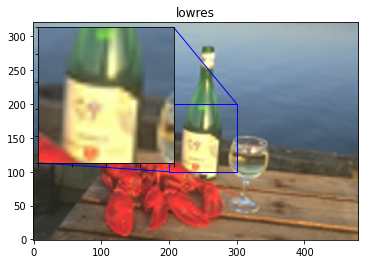

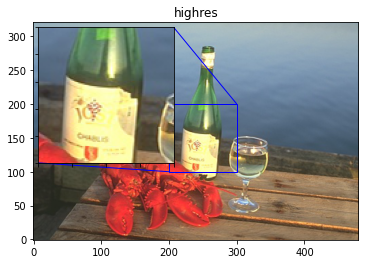

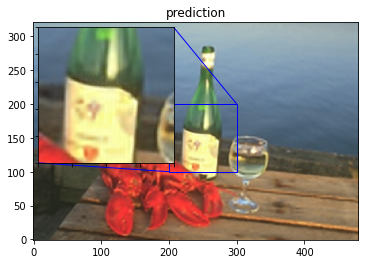

PSNR pf low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 25.9236


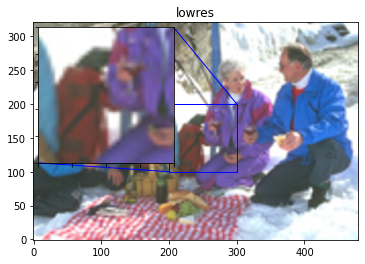

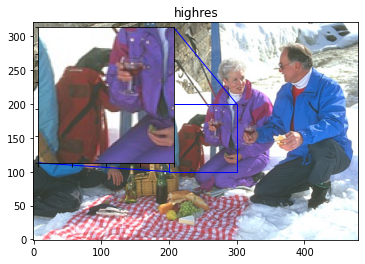

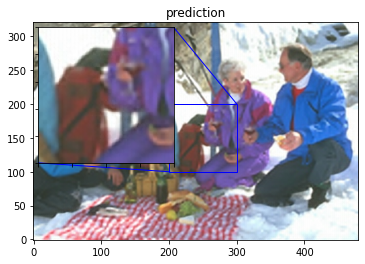

PSNR pf low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.3650


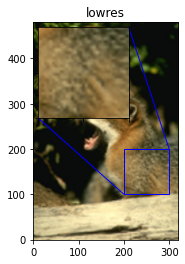

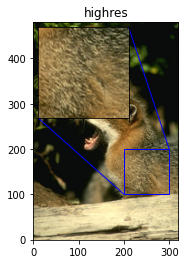

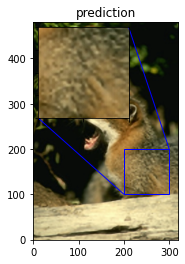

PSNR pf low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.2690


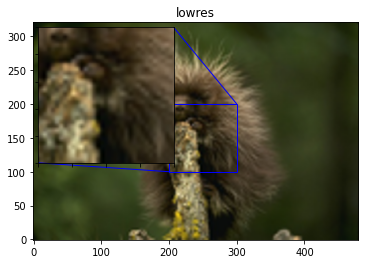

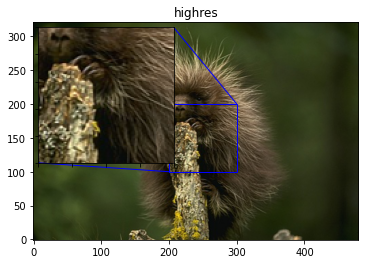

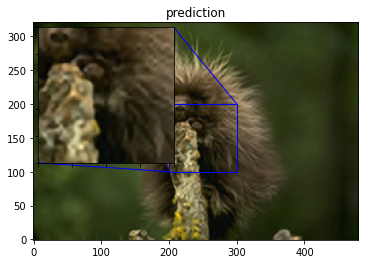

PSNR pf low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.3502


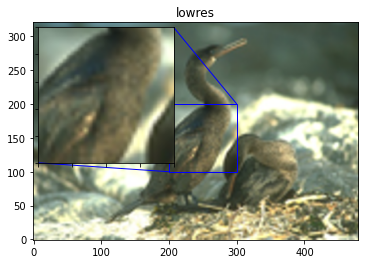

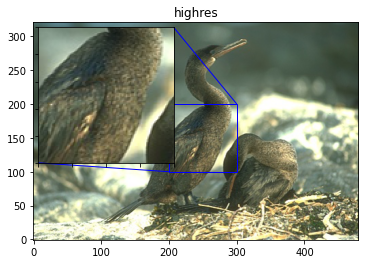

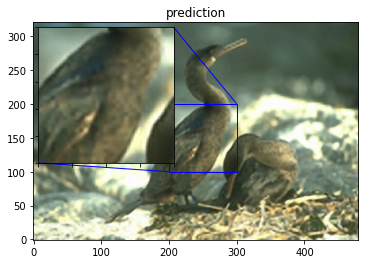

PSNR pf low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.5701


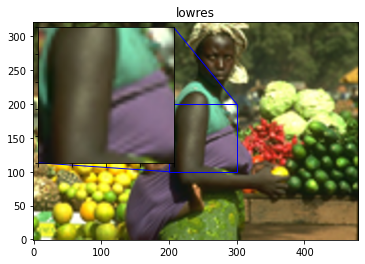

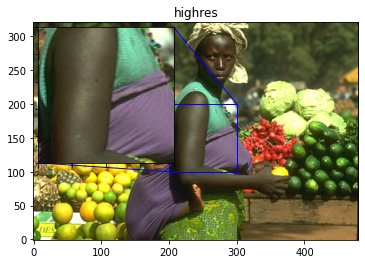

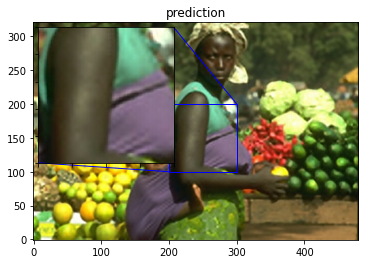

PSNR pf low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 27.1706


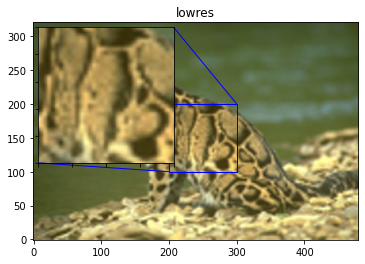

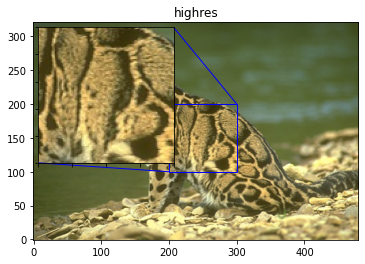

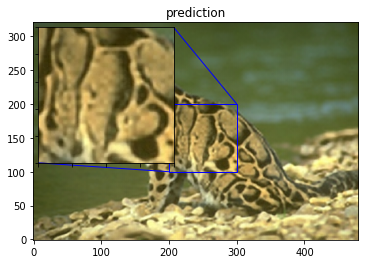

PSNR pf low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.7389


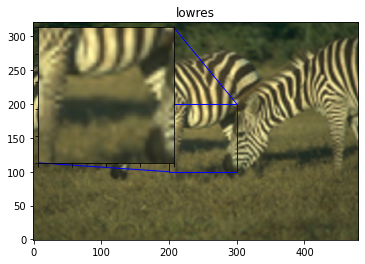

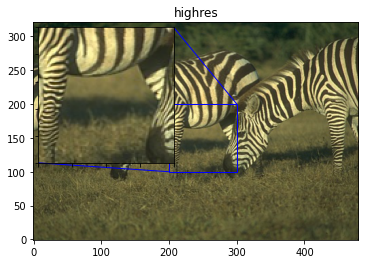

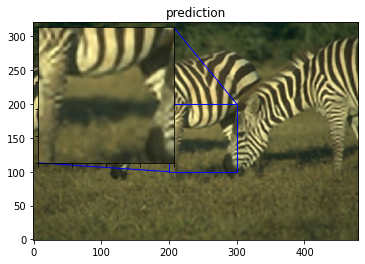

PSNR pf low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 30.0455


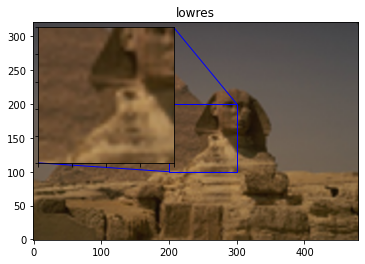

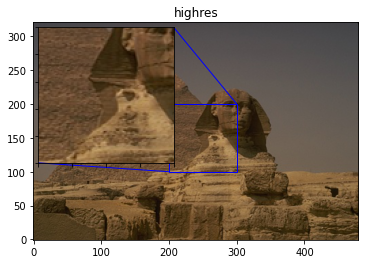

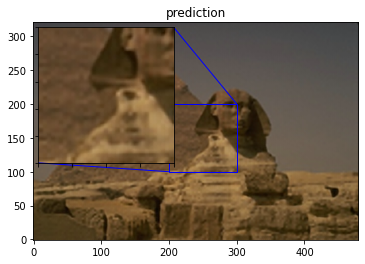

PSNR pf low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.6969


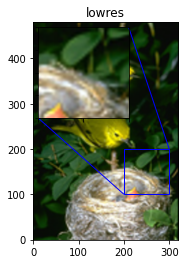

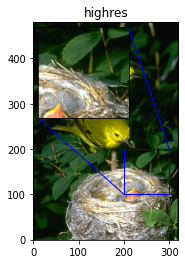

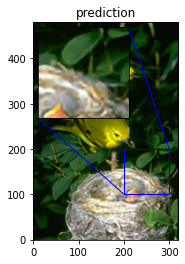

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstruction is 27.3443


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
  img = load_img(test_img_path)
  lowres_input = get_lowres_image(img, upscale_factor)
  w = lowres_input.size[0] *upscale_factor
  h = lowres_input.size[1] * upscale_factor
  highres_img = img.resize((w, h))
  prediction = upscale_image(model, lowres_input)
  lowres_img = lowres_input.resize((w, h))
  lowres_img_arr = img_to_array(lowres_img)
  highres_img_arr = img_to_array(highres_img)
  predict_img_arr = img_to_array(prediction)
  bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
  test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)


  total_bicubic_psnr += bicubic_psnr
  total_test_psnr += test_psnr

  print("PSNR pf low resolution image and high resolution image is %.4f" % bicubic_psnr)
  print("PSNR of predict and high resolution is %.4f" % test_psnr)
  plot_results(lowres_img, index, "lowres")
  plot_results(highres_img, index, "highres")
  plot_results(prediction, index, "prediction")


print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstruction is %.4f" % (total_test_psnr / 10))